In [1]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from modelutils import *
from quant import *
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from dataclasses import dataclass
from torch.utils.data import SubsetRandomSampler

c:\Users\igor-\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\utils\_runtime.py:185: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:

LOAD = True
SAVE = False
DEBUG = False 
@dataclass
class Args(object):
    nsamples: int = 4
    sparsity = 0.3
    prunen: int = 0
    prunem: int = 0
    percdamp = .01
    blocksize: int = 4
    batch_size: int = 16

args = Args()
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [3]:
# Step 1: Data Preparation
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)

# Confirm if data is loaded
len(trainset), len(testset)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 28*28) # Flatten the image
        self.fc2 = nn.Linear(28*28, 28*28)
        self.fc3 = nn.Linear(28*28, 10) # 10 classes for MNIST

    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

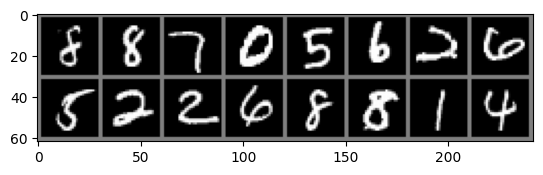


 8     8     7     0     5     6     2     6     
 5     2     2     6     8     8     1     4    


In [5]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'\n {classes[labels[j]]:5s}' if j%8 == 0 else ''.join(f'{classes[labels[j]]:5s}') for j in range(args.batch_size)))

In [6]:
images.shape

torch.Size([16, 1, 28, 28])

In [7]:
model = MLP().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 3
train_losses, test_losses = [], []

In [8]:
if LOAD:
    PATH = './mnist_net.pth'
    model.load_state_dict(torch.load(PATH))
else:    
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for images, labels in testloader:
                    log_ps = model(images.to(device))
                    test_loss += criterion(log_ps, labels.to(device))
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.to(device).view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {e+1}/{epochs}.. "
                f"Train loss: {running_loss/len(trainloader):.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {accuracy/len(testloader):.3f}")

    print('Finished Training')
    if SAVE:
        PATH = './mnist_net.pth'
        torch.save(model.state_dict(), PATH)
        plt.plot(train_losses, label='Training loss')
        plt.plot(list(map(torch.Tensor.cpu, test_losses)), label='Validation loss')
        plt.legend(frameon=False)
        plt.show()


RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 784]) from checkpoint, the shape in current model is torch.Size([784, 784]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([784]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([784, 784]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([784]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([10, 64]) from checkpoint, the shape in current model is torch.Size([10, 784]).

In [ ]:
test_losses, train_losses;

In [9]:
def infer_and_compute_accuracy_random_samples(model, dataset, num_samples=1000):
    model.eval()  # Set the model to evaluation mode
    
    # Create a list of indices and shuffle them
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    idx = indices[:num_samples]

    # Create a DataLoader with SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    testloader_random_samples = DataLoader(dataset, batch_size=64, sampler=sampler)

    correct_count, all_count = 0, 0
    for images, labels in testloader_random_samples:
        with torch.no_grad():
            outputs = model(images.view(images.shape[0], -1).to(device))
        
        _, predicted = torch.max(outputs, 1)
        correct_count += (predicted == labels.to(device)).sum().item()
        all_count += labels.size(0)
    
    print("Number of Samples tested =", all_count)
    print("\nModel Accuracy =", (correct_count / all_count))

# Assuming testset is your test dataset
# Call the function
infer_and_compute_accuracy_random_samples(model, testset, num_samples=1000)


Number of Samples tested = 1000

Model Accuracy = 0.116


In [10]:
modules = list(model.modules())
module_0 = modules[0]

In [11]:
modules

[MLP(
   (fc1): Linear(in_features=784, out_features=784, bias=True)
   (fc2): Linear(in_features=784, out_features=784, bias=True)
   (fc3): Linear(in_features=784, out_features=10, bias=True)
 ),
 Linear(in_features=784, out_features=784, bias=True),
 Linear(in_features=784, out_features=784, bias=True),
 Linear(in_features=784, out_features=10, bias=True)]

In [12]:
module_0

MLP(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
# layers = list(find_layers(net).values())
layers = list(find_layers(model))
layers

['fc1', 'fc2', 'fc3']

In [14]:
find_layers(model)

{'fc1': Linear(in_features=784, out_features=784, bias=True),
 'fc2': Linear(in_features=784, out_features=784, bias=True),
 'fc3': Linear(in_features=784, out_features=10, bias=True)}

In [15]:
layers

['fc1', 'fc2', 'fc3']

In [16]:
@torch.no_grad()
def mlp_sequential(model, dataloader, dev):
    print('Starting ...')

    # use_cache = model.config.use_cache
    # model.config.use_cache = False
    
    layers = list(model.modules())[0]
    
    print(layers)
    layers = layers.to(dev)
    layers_dict = find_layers(layers); print(layers_dict)
    dtype = next(iter(model.parameters())).dtype
    inps = torch.zeros(
        (args.batch_size, 28*28), dtype=dtype, device=dev
    )
    torch.cuda.empty_cache()

    outs = torch.zeros_like(inps)
    # attention_mask = cache['attention_mask']

    print('Ready.')
    gpts = {}
    for layer_name, layer_obj in layers_dict.items():
        
        layer = layer_obj.to(dev)

        # subset = find_layers(layer)
        
        # gpts = {}
        # for name in subset:
        gpts[layer_name] = SparseGPT(layer_obj)
        print("layer_obj ", layer_obj)
        def add_batch(layer_name):
            def tmp(_, inp, out):
                gpts[layer_name].add_batch(inp[0].data, out.data)
            return tmp
        handles = []
        
        handles.append(layer_obj.register_forward_hook(add_batch(layer_name)))
        for j in range(args.batch_size):
            # outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask)[0]
            outs[j] = layer(inps[j].unsqueeze(0))[0]
        for h in handles:
            h.remove()

        
        print(layer_name)
        print('Pruning ...')
        sparsity = args.sparsity
        gpts[layer_name].fasterprune(
                sparsity, prunen=args.prunen, prunem=args.prunem, percdamp=args.percdamp, blocksize=args.blocksize
            )
        gpts[layer_name].free()

        for j in range(args.batch_size):
            # outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask)[0]
            outs[j] = layer(inps[j].unsqueeze(0))[0]

        layer = layer.cpu()
        del layer
        torch.cuda.empty_cache()

        inps, outs = outs, inps


In [18]:
class SparseGPT:

    def __init__(self, layer):
        self.layer = layer
        print(layer)
        print(type(layer))
        self.dev = self.layer.weight.device
        W = layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.rows = W.shape[0]
        self.columns = W.shape[1]
        self.H = torch.zeros((self.columns, self.columns), device=self.dev)
        self.nsamples = 0

    def add_batch(self, inp, out, blocksize=1024):
        if DEBUG:
            self.inp1 = inp
            self.out1 = out
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear) or isinstance(self.layer, transformers.Conv1D):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()
        self.H *= self.nsamples / (self.nsamples + tmp)
        self.nsamples += tmp
        inp = math.sqrt(2 / self.nsamples) * inp.float()
        self.H += inp.matmul(inp.t())

    def fasterprune(
        self, sparsity, prunen=0, prunem=0, blocksize=128, percdamp=.01
    ):
        W = self.layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        W = W.float()

        if hasattr(self, 'quantizer'):
            if not self.quantizer.ready():
                self.quantizer.find_params(W, weight=True)

        tick = time.time()

        H = self.H
        del self.H
        dead = torch.diag(H) == 0
        H[dead, dead] = 1
        W[:, dead] = 0

        Losses = torch.zeros(self.rows, device=self.dev)

        damp = percdamp * torch.mean(torch.diag(H))
        diag = torch.arange(self.columns, device=self.dev)
        H[diag, diag] += damp
        H = torch.linalg.cholesky(H)
        H = torch.cholesky_inverse(H)
        H = torch.linalg.cholesky(H, upper=True)
        Hinv = H

        mask = None

        for i1 in range(0, self.columns, blocksize):
            i2 = min(i1 + blocksize, self.columns)
            count = i2 - i1

            W1 = W[:, i1:i2].clone()
            Q1 = torch.zeros_like(W1)
            Err1 = torch.zeros_like(W1)
            Losses1 = torch.zeros_like(W1)
            Hinv1 = Hinv[i1:i2, i1:i2]

            if prunen == 0: 
                if mask is not None:
                    mask1 = mask[:, i1:i2]
                else:
                    tmp = W1 ** 2 / (torch.diag(Hinv1).reshape((1, -1))) ** 2
                    thresh = torch.sort(tmp.flatten())[0][int(tmp.numel() * sparsity)]
                    mask1 = tmp <= thresh
            else:
                mask1 = torch.zeros_like(W1) == 1

            for i in range(count):
                w = W1[:, i]
                d = Hinv1[i, i]

                if prunen != 0 and i % prunem == 0:
                    tmp = W1[:, i:(i + prunem)] ** 2 / (torch.diag(Hinv1)[i:(i + prunem)].reshape((1, -1))) ** 2
                    mask1.scatter_(1, i + torch.topk(tmp, prunen, dim=1, largest=False)[1], True)

                q = w.clone()
                q[mask1[:, i]] = 0

                if hasattr(self, 'quantizer'):
                    q = quantize(
                        q.unsqueeze(1), self.quantizer.scale, self.quantizer.zero, self.quantizer.maxq
                    ).flatten()

                Q1[:, i] = q
                Losses1[:, i] = (w - q) ** 2 / d ** 2

                err1 = (w - q) / d
                W1[:, i:] -= err1.unsqueeze(1).matmul(Hinv1[i, i:].unsqueeze(0))
                Err1[:, i] = err1

            W[:, i1:i2] = Q1
            Losses += torch.sum(Losses1, 1) / 2

            W[:, i2:] -= Err1.matmul(Hinv[i1:i2, i2:])

            if DEBUG:
                self.layer.weight.data[:, :i2] = W[:, :i2]
                self.layer.weight.data[:, i2:] = W[:, i2:]
                print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))
                print(torch.sum(Losses))

        torch.cuda.synchronize()
        print('time %.2f' % (time.time() - tick))
        print('error', torch.sum(Losses).item())

        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.layer.weight.data = W.reshape(self.layer.weight.shape).to(self.layer.weight.data.dtype)
        if DEBUG:
            print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))

    def free(self):
        if DEBUG:
            self.inp1 = None
            self.out1 = None
        self.H = None
        torch.cuda.empty_cache()


In [19]:
mlp_sequential(model, testloader, device)

Starting ...
MLP(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=10, bias=True)
)
{'fc1': Linear(in_features=784, out_features=784, bias=True), 'fc2': Linear(in_features=784, out_features=784, bias=True), 'fc3': Linear(in_features=784, out_features=10, bias=True)}
Ready.
Linear(in_features=784, out_features=784, bias=True)
<class 'torch.nn.modules.linear.Linear'>
layer_obj  Linear(in_features=784, out_features=784, bias=True)
fc1
Pruning ...
time 0.61
error 0.0
Linear(in_features=784, out_features=784, bias=True)
<class 'torch.nn.modules.linear.Linear'>
layer_obj  Linear(in_features=784, out_features=784, bias=True)
fc2
Pruning ...
time 0.41
error 3.123769783996977e-05
Linear(in_features=784, out_features=10, bias=True)
<class 'torch.nn.modules.linear.Linear'>
layer_obj  Linear(in_features=784, out_features=10, bias=True)


RuntimeError: The expanded size of the tensor (784) must match the existing size (10) at non-singleton dimension 0.  Target sizes: [784].  Tensor sizes: [10]

In [57]:
w_0 = layers[0].weight.data.clone()

In [75]:
sgpt = SparseGPT(layers[0])

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
<class 'torch.nn.modules.conv.Conv2d'>


In [70]:
sgpt.fasterprune(0.1)

time 0.04
error 0.0


In [71]:
np.alltrue((sgpt.layer.weight.data == 0).cpu().numpy())

True

<generator object Module.modules at 0x0000021AB2C5BA70>